# **Crypto Insights: Аналітика ринку та симуляція інвестицій для топ-5 криптовалют**

---

## **Вступ**
Мета цього проєкту — дослідити динаміку криптовалютного ринку та оцінити ефективність різних інвестиційних стратегій для п’яти провідних монет: 
| Symbol |  Повна назва |
|--------|--------------|
| BTC    | Bitcoin      |
| ETH    | Ethereum     |
| SOL    | Solana       |
| XRP    | Ripple       |
| ADA    | Cardano      |

  Дослідження включає :
- аналіз історичних цінових рядів та ринкової капіталізації;  
- симуляції інвестиційних стратегій;  
- порівняння ризику та прибутковості.

Проєкт дозволяє оцінити ефективність різних інвестиційних стратегій у контексті криптовалютного ринку.
Аналіз охоплює як рівень прибутковості, так і рівень ризику (волатильність, просадки), що забезпечує збалансовану оцінку результатів. 

Отримані результати можуть бути корисними *інвесторам-початківцям* — як орієнтир для вибору підходу до інвестування, *трейдерам* — для оцінки ризик/прибутковості різних монет та *аналітикам* — як основа для подальших досліджень і візуалізації у бізнес-дашбордах.

---
## **Дані**
Дані було завантажено через **CoinGecko API** за допомогою власного Python-скрипта (`scripts/fetch_api_data.py`) і збережено у форматі CSV для подальшої роботи.   
### Опис колонок датасету
| Колонка          | Опис                                                                 |
|------------------|----------------------------------------------------------------------|
| date             | Дата спостереження                                                   |
| coin_id          | Ідентифікатор монети у CoinGecko                                     |
| symbol           | Біржовий тикер (BTC, ETH, SOL, XRP, ADA)                             |
| price_usd        | Ціна монети у доларах США                                            |
| market_cap_usd   | Ринкова капіталізація монети                                         |
| volume_usd       | Добовий торговий обсяг у доларах США                                 |

### Терміни та визначення

*Волатильність*  - міра коливання цін криптовалют за певний період. Цей показник використовується для оцінки стабільності активів і коригування стратегій управління ризиком. Висока волатильність свідчить про більший ризик інвестицій.

*Диверсифікація* - стратегія, коли інвестор розподіляє свої кошти між кількома різними криптовалютами, щоб знизити ризики і підвищити стабільність портфеля.

*Капіталізація*  - загальна ринкова вартість всіх монет конкретної криптовалюти. Використовується для порівняння масштабів різних криптоактивів і визначення їх частки на ринку.

*Ліквідність*  - характеризує швидкість і легкість, з якою актив можна купити або продати без суттєвої зміни його ціни. Важлива для оцінки практичної можливості реалізації стратегій інвестування та управління ризиком.

*Портфель*  - сукупність інвестицій в різні активи, що дозволяє оцінити загальний ризик та прибутковість. У проєкті портфель використовується для аналізу комбінованих стратегій і взаємозв’язку між різними криптовалютами.

---
## **Бізнес-питання**
Для забезпечення цілісності аналізу були сформовані ключові питання, що логічно переходять від описової аналітики до експериментальної та прогнозної частини:
1. **Динаміка цін:** як змінювалися курси BTC, ETH, SOL, XRP, ADA протягом року?
2. **Волатильність:** яка монета є найризикованішою, а яка стабільнішою?
3.	**Просадки:** які максимальні падіння цін переживала кожна монета?
4.	**Кореляція:** чи рухаються монети синхронно, і які з них найбільш пов’язані?
5.  **Торгові обсяги та ціна:** чи підтверджується гіпотеза, що високі обсяги торгів супроводжуються більшими ціновими рухами?
6.  **Статистична перевірка (t-test):** чи є відмінності у середній прибутковості між днями з високими та низькими обсягами?
7.	**Сезонність:** чи існують денні та місячні патерни (дні тижня, місяці), коли монети показують кращу/гіршу динаміку?
8.	**ROI-аналіз:** який фінансовий результат дали б одноразові інвестиції у $1000 для кожної монети?
9.	**Порівняння стратегій:** яка стратегія ефективніша?
10.	**Risk–Return Map:** чи справді більший прибуток супроводжується більшим ризиком?
11.	Чи можливо передбачити динаміку цін на 7 днів уперед?
12.	**Рейтинг монет:** яка криптовалюта є найкращою за співвідношенням прибуток/ризик?
---


## **A. Підготовка середовища та даних**

In [2]:
# Імпорт бібліотек
import pandas as pd
import numpy as np
import os
from datetime import datetime, timezone
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.colors import Normalize

from scipy.stats import ttest_ind
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Завантаження даних
market_daily = pd.read_csv('data/crypto_market.csv')

In [3]:
# Первинний огляд даних 

# Часовий діапазон
market_daily["date"] = pd.to_datetime(market_daily["date"])
print("\nПеріод:", market_daily['date'].min().date(), "→", market_daily['date'].max().date())

# Переглядаємо перші рядки
print("\n=== Попередній перегляд ===")
display(market_daily.head())

# Інформація про колонки
print("\n=== Інформація про датафрейм ===")
market_daily.info()

# Базова статистика
print("\n=== Загальна статистика ===")
display(market_daily.describe())

print("\n=== Базова статистика цін по монетах ===")
stats_per_coin = market_daily.groupby("symbol")["price_usd"].describe().round(2)
display(stats_per_coin)


Період: 2024-09-14 → 2025-09-13

=== Попередній перегляд ===


,date,coin_id,symbol,price_usd,market_cap_usd,volume_usd
0,2024-09-14,bitcoin,BTC,60620.627473,1.197832e+12,3.191974e+10
1,2024-09-15,bitcoin,BTC,60003.299401,1.185256e+12,1.580012e+10
2,2024-09-16,bitcoin,BTC,59214.802268,1.169678e+12,1.728960e+10
3,2024-09-17,bitcoin,BTC,58211.123231,1.150499e+12,3.219657e+10
4,2024-09-18,bitcoin,BTC,60317.031979,1.191819e+12,3.419117e+10



=== Інформація про датафрейм ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   date            1830 non-null   datetime64[ns]
 1   coin_id         1830 non-null   object        
 2   symbol          1830 non-null   object        
 3   price_usd       1830 non-null   float64       
 4   market_cap_usd  1830 non-null   float64       
 5   volume_usd      1830 non-null   float64       
dtypes: datetime64[ns](1), float64(3), object(2)
memory usage: 85.9+ KB

=== Загальна статистика ===


,date,price_usd,market_cap_usd,volume_usd
count,1830,1830.000000,1.830000e+03,1.830000e+03
mean,2025-03-15 11:56:03.934426112,19623.842306,4.946950e+11,1.668888e+10
min,2024-09-14 00:00:00,0.323973,1.154625e+10,1.866016e+08
25%,2024-12-14 00:00:00,2.065064,6.425709e+10,2.477420e+09
50%,2025-03-15 12:00:00,169.987787,1.331248e+11,7.072503e+09
75%,2025-06-15 00:00:00,3416.628778,4.113959e+11,2.477249e+10
max,2025-09-13 00:00:00,123560.993636,2.458895e+12,1.904603e+11
std,NaN,38435.466706,7.209692e+11,2.151359e+10



=== Базова статистика цін по монетах ===


,count,mean,std,min,25%,50%,75%,max
symbol,,,,,,,,
ADA,366.0,0.73,0.21,0.32,0.62,0.74,0.86,1.23
BTC,366.0,95047.53,16295.00,58211.12,84462.29,97202.16,106910.13,123560.99
ETH,366.0,2893.84,791.85,1471.36,2422.16,2658.98,3416.63,4829.23
SOL,366.0,174.98,35.37,105.49,146.82,169.99,199.80,262.56
XRP,366.0,2.13,0.83,0.50,2.07,2.28,2.66,3.56


### Структура датасету
- Датасет містить **1830 записів та 6 колонок**, що охоплюють п’ять криптовалют у період **2024-09-14 → 2025-09-13** (366 днів).
- Діапазон цін значно варіюється: від **$0.32 (ADA) до $123,561 (BTC)**, що відображає різну капіталізацію та масштаб монет.
- **Ринкова капіталізація** коливається від **~11 млрд $ до ~2.46 трлн $**, що підтверджує різні рівні вагомості криптовалют на ринку.

### Якість даних
- Усі поля (`date`, `coin_id`, `symbol`, `price_usd`, `market_cap_usd`, `volume_usd`) **повні, без пропусків**.
- Кількість записів **збалансована**: кожна монета має 366 рядків, що відповідає річному діапазону.
- Значення **реалістичні**: наприклад, діапазон BTC (58k–123k $) узгоджується з історичними трендами.
- **Відсутні аномалії**: нульові чи від’ємні значення у цінах, капіталізації чи обсягах не зафіксовані.
- Дані **рівномірно розподілені у часі**, без пропусків у часовій послідовності.

✅ Загалом, дані відзначаються **високою структурованістю та якістю**, що дозволяє їх використовувати для подальшого аналізу та побудови моделей.

### Інженерія ознак

Щоб зробити аналіз більш глибоким, додано нові колонки у датасет. Що допомагають виміряти не лише ціну, але й ризики та потенційні сигнали для інвестицій.

1. **return_pct** — щоденна відсоткова зміна ціни. Показує, на скільки % сьогоднішня ціна відрізняється від учорашньої. Використовується для аналізу прибутковості та побудови волатильності.  
Формула: `(ціна_t / ціна_(t-1) - 1) * 100`

3. **rolling_vol_14d** — 14-денна ковзна волатильність, дозволяє оцінити, наскільки монета стабільна чи ризикована у певний період. Розрахунок стандартного відхилення щоденних змін за 14 днів.

4. **drawdown_pct** — показує найбільше зниження вартості активу або портфеля від локального максимуму до наступного мінімуму. Важливий для оцінки потенційних втрат та стійкості стратегії у кризових умовах ринку.  
Формула: `(ціна - максимум_до_цього) / максимум_до_цього * 100`  

5. **weekday / month** — день тижня та місяць. Використовуються для виявлення сезонності та повторюваних патернів у поведінці цін.  

6. **is_dip_3d** — індикатор «просадки» (ціна падає ≥5% за 3 дні). Визначає моменти, коли відбулося значне падіння. Використовується у стратегії «купувати на просадках».  
`is_dip_3d`: дорівнює `1`, якщо падіння ≥5% за 3 дні, інакше `0`.


In [4]:
# Додаткові колонки до market_daily
market_daily["return_pct"] = market_daily.groupby("coin_id")["price_usd"].pct_change() * 100
market_daily["rolling_vol_14d"] = market_daily.groupby("coin_id")["return_pct"].rolling(14).std().reset_index(0, drop=True)
market_daily["drawdown_pct"] = market_daily.groupby("coin_id")["price_usd"].transform(lambda x: (x - x.cummax())/x.cummax()*100)
market_daily["weekday"] = market_daily["date"].dt.day_name()
market_daily["month"] = market_daily["date"].dt.month
market_daily["return_3d"] = market_daily.groupby("coin_id")["price_usd"].pct_change(3) * 100
market_daily["is_dip_3d"] = (market_daily["return_3d"] <= -5).astype(int)

market_daily.head()

,date,coin_id,symbol,price_usd,market_cap_usd,volume_usd,return_pct,rolling_vol_14d,drawdown_pct,weekday,month,return_3d,is_dip_3d
0,2024-09-14,bitcoin,BTC,60620.627473,1.197832e+12,3.191974e+10,NaN,NaN,0.000000,Saturday,9,NaN,0
1,2024-09-15,bitcoin,BTC,60003.299401,1.185256e+12,1.580012e+10,-1.018347,NaN,-1.018347,Sunday,9,NaN,0
2,2024-09-16,bitcoin,BTC,59214.802268,1.169678e+12,1.728960e+10,-1.314090,NaN,-2.319054,Monday,9,NaN,0
3,2024-09-17,bitcoin,BTC,58211.123231,1.150499e+12,3.219657e+10,-1.694980,NaN,-3.974727,Tuesday,9,-3.974727,0
4,2024-09-18,bitcoin,BTC,60317.031979,1.191819e+12,3.419117e+10,3.617708,NaN,-0.500812,Wednesday,9,0.522859,0


# **B. Базовий огляд**
### 1.	Динаміка цін монет за рік
**Мета:** Візуалізувати зміни ціни кожної монети за часом.  
**Очікуваний результат:** Визначити загальні тренди (зростання/падіння) та періоди підвищеної активності.

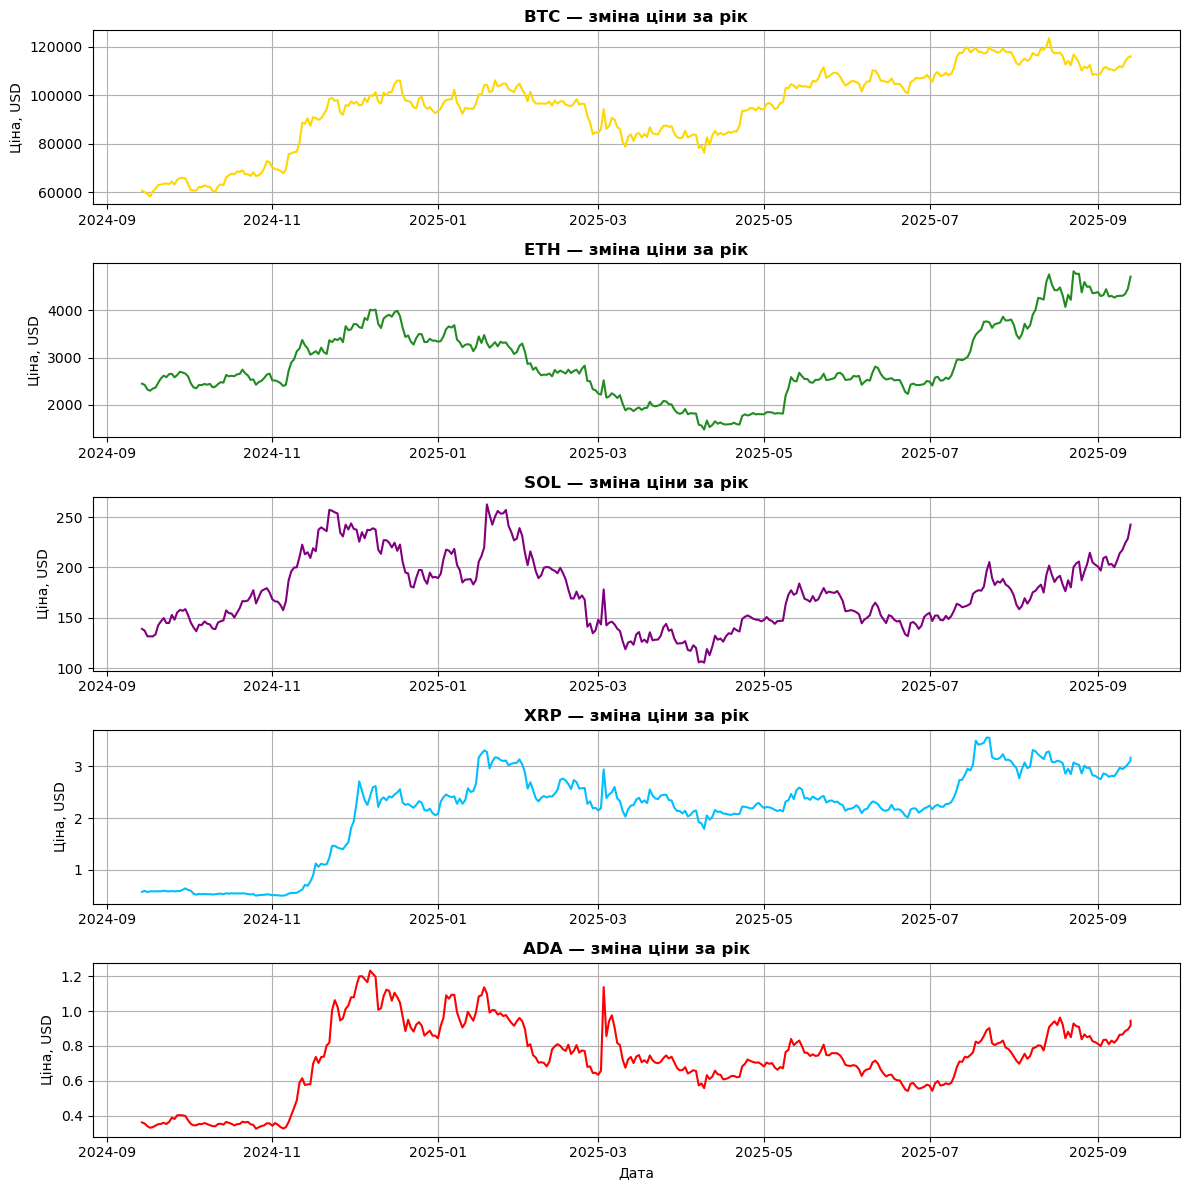

In [5]:
# Фіксуємо кольори для кожної монети
coin_colors = {
    "BTC": "#FFD700",   # золотий
    "ETH": "#228B22",   # зелений 
    "SOL": "#800080",   # фіолетовий
    "XRP": "#00BFFF",   # голубий 
    "ADA": "#FF0000"    # червоний
}

# Унікальні тікери монет
coins = market_daily['symbol'].unique()

# Область для графіків
fig, axes = plt.subplots(5, 1, figsize=(12, 12))
for i, coin in enumerate(coins):
    sub = market_daily[market_daily['symbol'] == coin]
    axes[i].plot(
        sub['date'], 
        sub['price_usd'], 
        label=coin, 
        color=coin_colors[coin]
    )
    axes[i].set_title(f"{coin} — зміна ціни за рік", fontweight="bold")
    axes[i].set_ylabel("Ціна, USD")
    axes[i].grid(True)

plt.xlabel("Дата")
plt.tight_layout()
plt.show()

**Висновки:**   
- **BTC** показує стабільний ап-тренд і є найбільш надійним активом для довгострокових інвестицій.  
- **ETH** та **XRP** мають сильний потенціал росту, але характеризуються вираженими корекціями.  
- **SOL** та **ADA** більш волатильні: підходять для активного трейдингу, але ризиковіші для пасивного утримання.

### 2. Волатильність
**Мета:** Порівняти ризиковість монет на основі їхніх щоденних відсоткових змін (`return_pct`) та 14-денної ковзної волатильності (`rolling_vol_14d`).  
**Очікуваний результат:** Визначити, яка з монет демонструє найбільші коливання (найризикованіша), а яка характеризується більш стабільною динамікою.

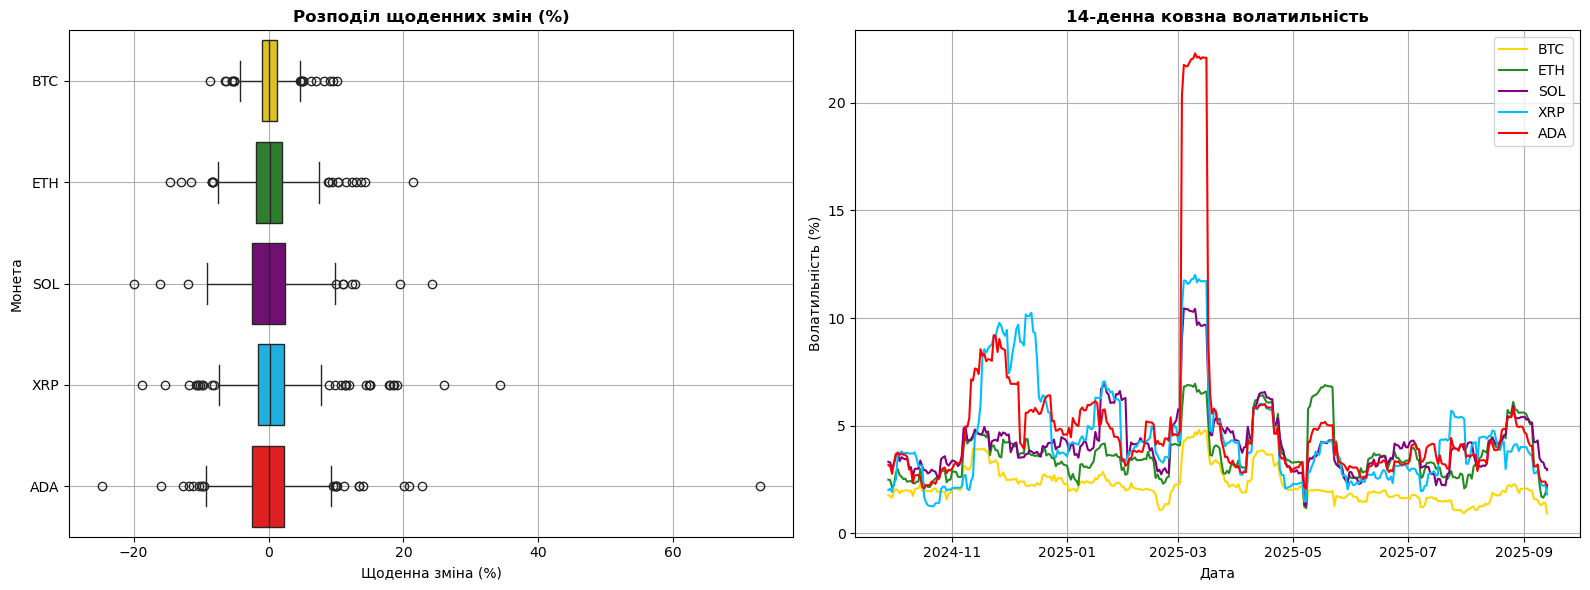

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16,6))

# 1. Boxplot для щоденних змін
sns.boxplot(
    data=market_daily,
    x="return_pct",
    y="symbol",
    hue="symbol",
    palette=coin_colors,
    vert=False,
    ax=axes[0]
)
axes[0].set_title("Розподіл щоденних змін (%)", fontweight="bold")
axes[0].set_xlabel("Щоденна зміна (%)")
axes[0].set_ylabel("Монета")
axes[0].grid()

# 2. Лінійний графік 14-денної волатильності
for i, coin in enumerate(coins):
    sub = market_daily[market_daily['symbol'] == coin]
    axes[1].plot(
        sub["date"], 
        sub["rolling_vol_14d"], 
        label=coin, 
        color=coin_colors[coin]
    )
axes[1].set_title("14-денна ковзна волатильність", fontweight="bold")
axes[1].set_xlabel("Дата")
axes[1].set_ylabel("Волатильність (%)")
axes[1].grid()
axes[1].legend()

plt.tight_layout()
plt.show()

**Висновки:**

- **BTC та ETH** — відносно стабільні монети. Щоденні зміни зазвичай у межах ±5%, волатильність коливається на рівні 5–7%. Це робить їх більш передбачуваними для довгострокових інвестицій.  
- **SOL та ADA** — найбільш волатильні. Часті великі відхилення та різкі стрибки (>20%) свідчать про високий ризик і спекулятивний характер цих активів.  
- **XRP** — займає середню позицію: здебільшого стабільний, але періодично демонструє різкі коливання.  

### 3. Просадки 
**Мета:** Оцінити максимальні просідання від локальних піків для кожної криптовалюти (`drawdown_pct`).  
**Очікуваний результат:** Сформувати уявлення про найгірші сценарії падіння, з якими може зіткнутися інвестор.

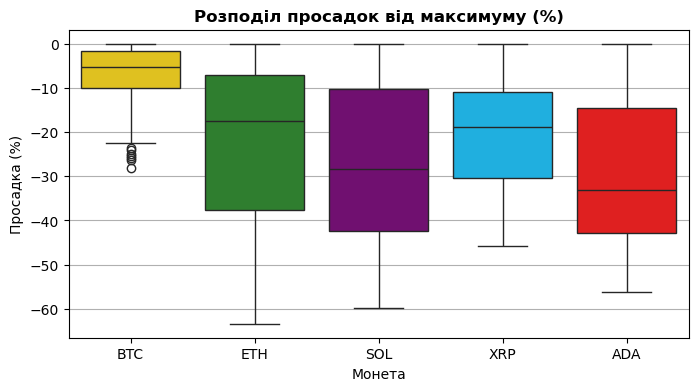

In [7]:
plt.figure(figsize=(8,4))
sns.boxplot(
    data=market_daily,
    x="symbol", 
    y="drawdown_pct",
    hue="symbol",
    palette=coin_colors
    )

plt.title("Розподіл просадок від максимуму (%)", fontweight="bold")
plt.xlabel("Монета")
plt.ylabel("Просадка (%)")
plt.grid(axis='y')

plt.show()

**Висновки:**

- **BTC** — найменші просадки: більшість у межах −10…−20%, рідко нижче −30%. Найстабільніший актив.  
- **ETH** — просадки значно глибші: часто понад −40%, окремі випадки до −60%.  
- **SOL, ADA** — найбільш ризиковані: медіана близько −30%, максимальні падіння понад −50%.  
- **XRP** — займає середню позицію: типові просадки −20…−30%, інколи до −40%.  

# **С. Взаємозв’язки та ринкові показники**
### 4. Кореляції між монетами  
**Мета:** Визначити, наскільки синхронно рухаються ціни різних криптовалют, чи є між ними сильні або слабкі взаємозв’язки.  

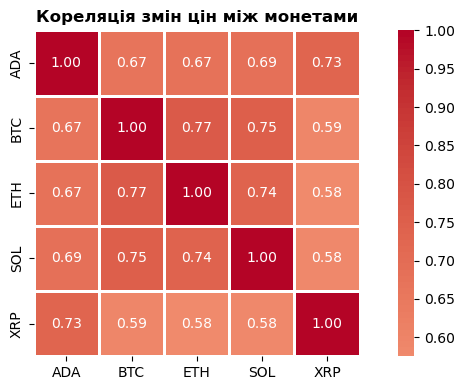

In [8]:
# Видалення дублікатів
market_daily_no_dup = market_daily.drop_duplicates(subset=['date','symbol'])

# Перетворення у формат wide: дати × монети
returns = market_daily_no_dup.pivot(index="date", columns="symbol", values="return_pct")

# Розрахунок ореляції між монетами
corr_matrix = returns.corr()

plt.figure(figsize=(8,4))
sns.heatmap(
    corr_matrix, 
    annot=True,
    fmt=".2f",
    center=0, 
    cmap="coolwarm", 
    square=True,
    linewidths=1
    )

plt.title("Кореляція змін цін між монетами", fontweight='bold')
plt.xlabel("")
plt.ylabel("")
plt.tight_layout()

plt.show()

**Висновки:**

- **BTC, ETH та SOL** демонструють найвищу взаємну кореляцію (0.74–0.77). Це означає, що їхні ціни змінюються майже синхронно, і падіння чи зростання однієї з монет часто відображається на інших.    
- **ADA** демонструє високий, але трохи нижчий рівень кореляції (0.67–0.73). Вона повторює загальний ринковий тренд, але з меншою інтенсивністю, що робить її більш гнучкою у періоди різких коливань.  
- **XRP** залишається у зоні середньо-високої кореляції (0.58–0.73). Він рухається разом із ринком, але іноді може відхилятися від загального тренду. 

### 5. Залежність між обсягами торгів і зміною ціни    
**Мета:** Дослідити, чи існує зв’язок між щоденними торговими обсягами та величиною відсоткових змін ціни для різних монет. Це допоможе перевірити гіпотезу, що періоди високих обсягів супроводжуються різкішими коливаннями.    

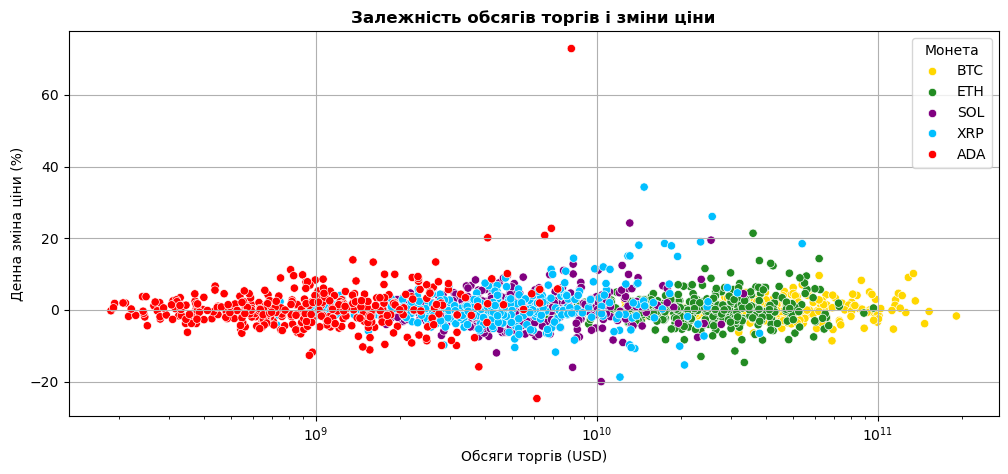

In [9]:
scatter_data = market_daily[['symbol', 'volume_usd', 'return_pct']].dropna()

plt.figure(figsize=(12,5))
sns.scatterplot(
    data=scatter_data,
    x='volume_usd', 
    y='return_pct', 
    hue='symbol', 
    palette=coin_colors
    )

plt.xscale('log')  # логарифмічна шкала для обсягів
plt.title("Залежність обсягів торгів і зміни ціни", fontweight='bold')
plt.xlabel("Обсяги торгів (USD)")
plt.ylabel("Денна зміна ціни (%)")
plt.legend(title="Монета")

plt.grid()
plt.show()

### 6. T-тест
**Мета:** Перевірити, чи підтверджується гіпотеза «великі обсяги → великі рухи цін» за допомогою статистичного тесту (t-test).  

**Гіпотези:**  
- **H₀:** середня денна дохідність у дні з високими та низькими обсягами **не відрізняється**.  
- **H₁:** середня денна дохідність у дні з високими та низькими обсягами **відрізняється**.

**Очікуваний результат:**  
- Якщо *p-value < 0.05* → відхиляємо H₀, тобто різниця статистично значуща.  
- Якщо *p-value ≥ 0.05* → не відхиляємо H₀, тобто доказів різниці немає.

**Пояснення:**  
Цей тест доповнює scatterplot «обсяги ↔ зміни цін»: якщо на графіку видно сильні відхилення при великих обсягах, t-test дозволяє формально перевірити, чи є це випадковим шумом, чи системною закономірністю.
> У дослідженні використовується **t-тест**, оскільки ми працюємо з вибірковими даними і не знаємо генеральне стандартне відхилення. Для великих вибірок t-тест практично збігається з z-тестом, але є універсальнішим і надійнішим методом.

In [10]:
results = []

# Для кожної монети окремо
for coin in market_daily['symbol'].unique():
    sub = market_daily[market_daily['symbol'] == coin].dropna(subset=['volume_usd', 'return_pct'])
    
    # Поріг: 70-й і 30-й квантилі обсягів
    low = sub[sub['volume_usd'] <= sub['volume_usd'].quantile(0.3)]['return_pct']
    high = sub[sub['volume_usd'] >= sub['volume_usd'].quantile(0.7)]['return_pct']
    
    # t-тест 
    t_stat, p_val = ttest_ind(high, low, equal_var=False)
    
    results.append({
        "Монета": coin,
        "Середнє (Low)": round(low.mean(), 3),
        "Середнє (High)": round(high.mean(), 3),
        "t-статистика": round(t_stat, 3),
        "p-value": round(p_val, 4),
        "Інтерпретація": "✅ Різниця значуща" if p_val < 0.05 else "Різниця незначуща"
    })

# Таблицю результатів
t_test_results = pd.DataFrame(results)
t_test_results

,Монета,Середнє (Low),Середнє (High),t-статистика,p-value,Інтерпретація
0,BTC,-0.060,0.607,2.043,0.0431,✅ Різниця значуща
1,ETH,0.090,0.690,1.096,0.2750,Різниця незначуща
2,SOL,0.055,1.000,1.482,0.1405,Різниця незначуща
3,XRP,0.039,2.093,2.574,0.0113,✅ Різниця значуща
4,ADA,-0.169,1.293,1.509,0.1338,Різниця незначуща


**Висновки:**

Аналіз поєднав два підходи — **візуалізацію (scatterplot)** та **статистику (t-тести)**, що дозволяє зробити комплексні висновки:  

- **BTC і XRP** підтвердили залежність між ліквідністю та рухами цін. На *візуалізації* добре видно, що при високих обсягах точки цих монет “витягуються” вгору, демонструючи цінові стрибки. *T-тест* підтвердив це статистично: у дні з високими обсягами середня дохідність значимо вища. Це означає, що для BTC і XRP **ріст обсягів може виступати раннім сигналом майбутніх цінових рухів**.   

- **ETH і SOL** показали менш виражену картину. *На візуалізації* помітне деяке збільшення розкиду при більших обсягах, але без чіткої структури. *T-тест* не дав статистично значущої різниці. Це може свідчити, що рухи ETH і SOL частіше визначаються іншими факторами: новинами, макротрендами, технічними оновленнями.  

- **ADA** має специфічний профіль. На *візуалізації* видно поодинокі сплески з високими обсягами та сильними ціновими відхиленнями. Проте *t-тест* показав, що середня різниця між low- і high-volume днями статистично не доведена. Це може вказувати на більш «хаотичну» динаміку, де **окремі події мають сильний, але несистемний вплив**.  


### 7. Сезонність і денні патерни  
**Мета:** Перевірити, чи існували у цій вибірці даних закономірності в динаміці цін залежно від дня тижня або місяця.   
**Очікуваний результат:** - Якщо існують патерни — певні дні або місяці показують стійкі позитивні чи негативні зміни, а якщо патернів немає — середні значення будуть розподілені доволі рівномірно.  

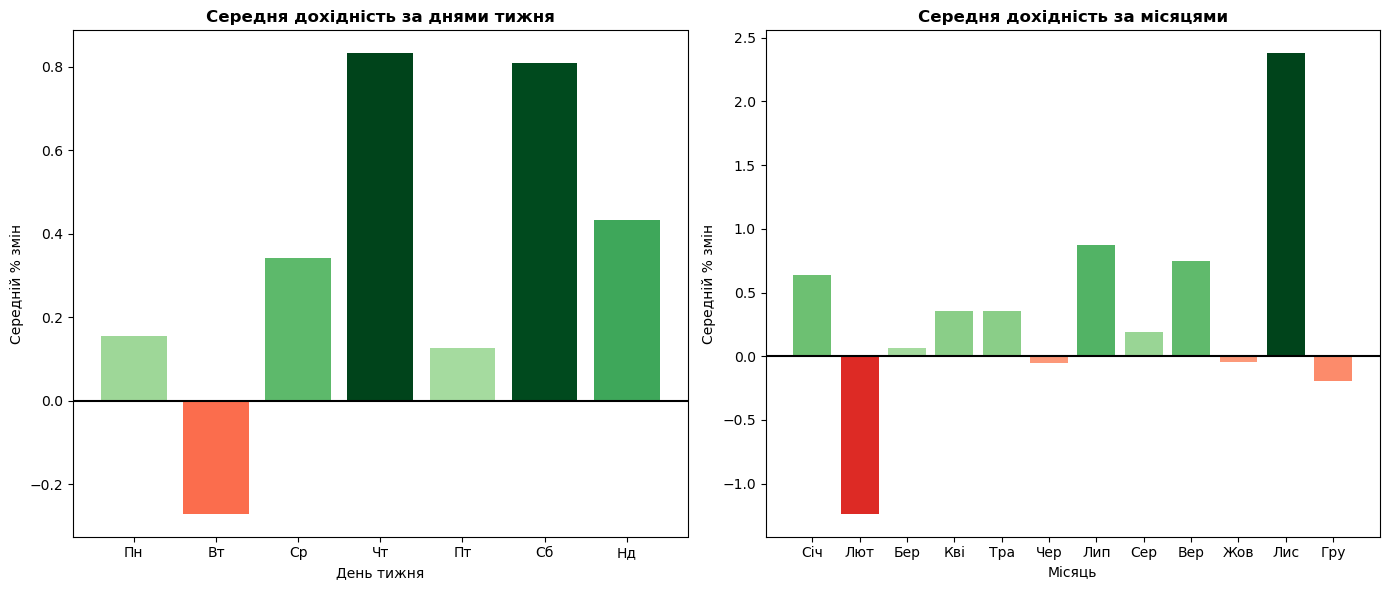

In [11]:
# Середня дохідність по днях і місяцях
avg_by_weekday = market_daily.groupby("weekday")["return_pct"].mean().reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
avg_by_month = market_daily.groupby("month")["return_pct"].mean().reindex(range(1,13))

# Назви днів і місяців
weekday_map = {
    "Monday": "Пн", "Tuesday": "Вт", "Wednesday": "Ср",
    "Thursday": "Чт", "Friday": "Пт", "Saturday": "Сб", "Sunday": "Нд"
}
month_map = {
    1: "Січ", 2: "Лют", 3: "Бер", 4: "Кві", 5: "Тра", 6: "Чер",
    7: "Лип", 8: "Сер", 9: "Вер", 10: "Жов", 11: "Лис", 12: "Гру"
}
avg_by_weekday.index = avg_by_weekday.index.map(weekday_map)
avg_by_month.index = avg_by_month.index.map(month_map)

# Побудова subplots
fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Дні тижня
values_day = avg_by_weekday.values
norm_day = Normalize(vmin=min(values_day), vmax=max(values_day))
colors_day = [cm.Greens(norm_day(v)) if v > 0 else cm.Reds(norm_day(abs(v))) for v in values_day]

axes[0].bar(
    avg_by_weekday.index, 
    avg_by_weekday.values, 
    color=colors_day
    )
axes[0].axhline(y=0, color='black', linestyle='-')
axes[0].set_title("Середня дохідність за днями тижня",  fontweight='bold')
axes[0].set_xlabel("День тижня")
axes[0].set_ylabel("Середній % змін")

# Місяці
values_month = avg_by_month.values
norm_month = Normalize(vmin=min(values_month), vmax=max(values_month))
colors_month = [cm.Greens(norm_month(v)) if v > 0 else cm.Reds(norm_month(abs(v))) for v in values_month]

axes[1].bar(
    avg_by_month.index, 
    avg_by_month.values, 
    color=colors_month
    )
axes[1].axhline(y=0, color='black', linestyle='-')
axes[1].set_title("Середня дохідність за місяцями",  fontweight='bold')
axes[1].set_xlabel("Місяць")
axes[1].set_ylabel("Середній % змін")

plt.tight_layout()
plt.show()

**Висновки:** 

- **Дні тижня.** У межах вибірки спостерігаються відмінності у середній дохідності між днями. Найнижчий результат зафіксовано у *вівторок*, тоді як *четвер* і *субота* показали найвищі середні значення. Це може свідчити про повторювані внутрішньотижневі закономірності у динаміці криптовалют.  
- **Місяці.** Певні календарні періоди також відрізнялися. *Лютий* демонструє від’ємний середній результат, тоді як *листопад* виділяється позитивною дохідністю. 


# **D. Інвестиційні стратегії**


Щоб зрозуміти, як різні інвестиційні підходи впливають на результативність криптовалютних вкладень, створено окрема таблиця симуляцій стратегій.  
Вона містить підсумкові значення прибутковості для кожної монети та кожної стратегії, дозволяючи оцінити, що працює краще: одноразова інвестиція, поступові внески чи купівля на просадках.

### Структура таблиці симуляцій

| Колонка            | Опис                                                                 |
|---------------------|----------------------------------------------------------------------|
| **coin**         | Ідентифікатор криптовалюти (BTC, ETH, SOL, XRP, ADA).               |
| **strategy**        | Використана стратегія інвестування (Buy&Hold, DCA, Buy-on-Dip).     |
| **amount_usd**      | Початковий обсяг інвестицій у доларах США (фіксовано $1000).         |
| **final_value_usd** | Кінцева вартість інвестиції після симуляції.                        |
| **profit_usd**      | Абсолютний прибуток у доларах (final_value_usd – amount_usd).       |
| **roi_pct**         | Відсоткова прибутковість від початкових інвестицій.                 |


Таким чином, ця таблиця виступає практичним інструментом для перевірки гіпотези: *чи виправдано інвестору використовувати складніші підходи, чи просте «купити й тримати» дає такий самий результат.*

In [12]:
# Основні функції для стратегій 
def one_time_invest(df, amount):
    """
    Симуляція одноразової інвестиції (Buy & Hold).
    Купівля на початку періоду та розрахунок кінцевої вартість інвестиції на кінець періоду.
    """
    start_price = df.iloc[0]["price_usd"]
    end_price = df.iloc[-1]["price_usd"]
    final_value = amount * (end_price / start_price)
    return final_value

def dca_invest(df, amount, periods=12):
    """
    Симуляція стратегії Dollar-Cost Averaging (DCA).
    Ділення інвестиції рівними частинами та щомісячна покупка монети за поточною ціною. 
    """
    monthly_amount = amount / periods
    df_monthly = df.set_index("date").resample("ME").first().reset_index()
    coins_bought = (monthly_amount / df_monthly["price_usd"]).sum()
    final_value = coins_bought * df.iloc[-1]["price_usd"]
    return final_value

def buy_on_dip(df, amount, threshold=-5):
    """
    Симуляція стратегії "Buy on Dip" (купівля на падінні).
    Купуємо лише один раз — під час першого серйозного падіння (3 дні поспіль та просідання ≤ threshold)
    """
    coins_bought = 0
    cash = amount
    num_trades = 0

    for i, row in df.iterrows():
        if row["return_3d"] <= threshold and cash > 0:
            coins_bought = cash / row["price_usd"]
            cash = 0
            num_trades = 1   
            break            

    final_value = coins_bought * df.iloc[-1]["price_usd"] + cash
    return final_value, num_trades

In [13]:
# Початкові параметри
initial_amount = 1000   # $1000 на кожну монету
coins = market_daily['symbol'].unique()

# Результати симуляцій зберігатимемо у список
sim_results = []
    
# Запуск симуляцій для всіх монет
for coin in coins:
    df_coin = market_daily[market_daily["symbol"] == coin].reset_index(drop=True)
    
    # Buy & Hold
    final_value = one_time_invest(df_coin, initial_amount)
    roi = (final_value - initial_amount) / initial_amount * 100
    sim_results.append({
        "symbol": coin,
        "strategy": "Buy & Hold",
        "amount_usd": initial_amount,
        "final_value_usd": round(final_value, 2),
        "profit_usd": round(final_value - initial_amount, 2),
        "roi_pct": round(roi, 2)
    })
    
    # DCA
    final_value = dca_invest(df_coin, initial_amount, periods=12)
    roi = (final_value - initial_amount) / initial_amount * 100
    sim_results.append({
        "symbol": coin,
        "strategy": "DCA",
        "amount_usd": initial_amount,
        "final_value_usd": round(final_value, 2),
        "profit_usd": round(final_value - initial_amount, 2),
        "roi_pct": round(roi, 2)
    })
    
    # Buy on Dip
    final_value, _ = buy_on_dip(df_coin, initial_amount, threshold=-5)
    roi = (final_value - initial_amount) / initial_amount * 100
    sim_results.append({
        "symbol": coin,
        "strategy": "Buy on Dip",
        "amount_usd": initial_amount,
        "final_value_usd": round(final_value, 2),
        "profit_usd": round(final_value - initial_amount, 2),
        "roi_pct": round(roi, 2)
    })

# DataFrame 
sim_results = pd.DataFrame(sim_results)

### 8.  ROI-аналіз

**Мета:** Оцінити прибутковість монет у сценарії «купити і тримати». Це дозволяє визначити, які активи показали найбільший приріст вартості та як відрізнялася ефективність різних криптовалют у однакових умовах інвестування.

In [14]:
buy_hold = sim_results[sim_results["strategy"] == "Buy & Hold"].sort_values("roi_pct", ascending=False).reset_index(drop=True)
buy_hold

,symbol,strategy,amount_usd,final_value_usd,profit_usd,roi_pct
0,XRP,Buy & Hold,1000,5523.84,4523.84,452.38
1,ADA,Buy & Hold,1000,2617.19,1617.19,161.72
2,ETH,Buy & Hold,1000,1929.21,929.21,92.92
3,BTC,Buy & Hold,1000,1914.13,914.13,91.41
4,SOL,Buy & Hold,1000,1745.04,745.04,74.50


**Висновки:**

- **XRP та ADA** продемонструвавши найвищу дохідність.    
- **BTC та ETH** підтвердили роль базових активів — стабільне, але помірне зростання без різких стрибків.    
- **SOL** показала найскромніший приріст, проте залишилася у позитивній зоні. 

### 9. Порівняння інвестиційних стратегій

**Мета:** Порівняти ключові інвестиційні підходи, щоб визначити, чи вигідніше вкладати кошти одразу, поступово чи на просадках. Це дозволить оцінити, як різні стратегії впливають на результат інвестора в умовах волатильного крипторинку.

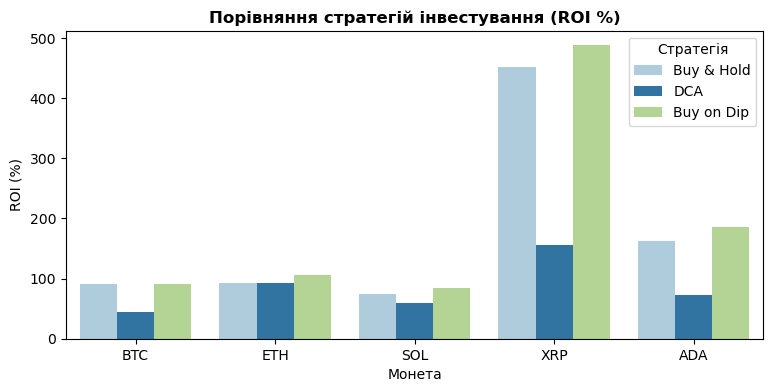

In [15]:
plot_data = sim_results[["symbol", "strategy", "roi_pct"]]

plt.figure(figsize=(9,4))
sns.barplot(
    data=plot_data,
    x="symbol",
    y="roi_pct",
    hue="strategy",
    palette="Paired"
)

plt.title("Порівняння стратегій інвестування (ROI %)", fontweight="bold")
plt.xlabel("Монета")
plt.ylabel("ROI (%)")
plt.legend(title="Стратегія")

plt.show()

**Висновки:**

- **Buy & Hold** показала себе найефективнішою у більшості випадків: проста стратегія «купив і тримай» забезпечує стабільно високі результати.   
- **DCA** виявилась найменш прибутковою: поступові покупки зменшують ризик, але водночас «згладжують» потенційний прибуток.   
- **Buy on Dip** може перевищувати Buy & Hold у деяких сценаріях, проте її успіх сильно залежить від вибору моменту входу.


### 10. Risk–Return Map

**Мета:** Побудувати карту «ризик–дохідність», де nочки відображатимуть монети та стратегії. Це дозволить оцінити, чи збігається очікувана логіка «більший дохід = більший ризик» у вибірці.

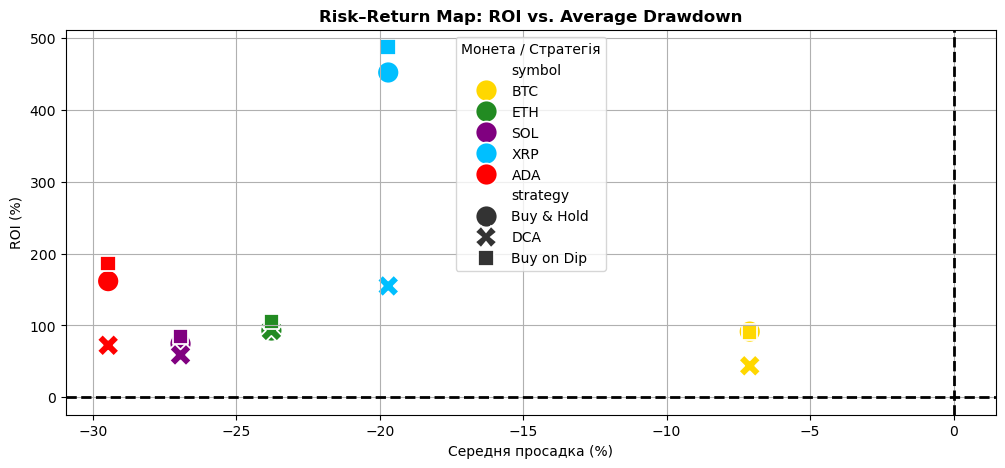

In [16]:
# Середня просадка для кожної монети
avg_drawdowns = (market_daily.groupby("symbol")["drawdown_pct"].mean())

# Об’єднання з таблицею симуляцій
risk_return = sim_results.merge(avg_drawdowns, on="symbol", how="left")

# Побудова Risk–Return Map
plt.figure(figsize=(12,5))
sns.scatterplot(
    data=risk_return,
    x="drawdown_pct", 
    y="roi_pct", 
    hue="symbol",
    palette=coin_colors,
    style="strategy", 
    s=250
)

plt.axhline(0, color="black", linestyle="--", linewidth=2)
plt.axvline(0, color="black", linestyle="--", linewidth=2)
plt.title("Risk–Return Map: ROI vs. Average Drawdown", fontweight="bold")
plt.xlabel("Середня просадка (%)")
plt.ylabel("ROI (%)")
plt.legend(title="Монета / Стратегія")
plt.grid()

plt.show()

**Висновки:**

- **XRP** — беззаперечний лідер: стратегія *Buy on Dip* дала майже +490% при середніх просадках ~–20%. Навіть *Buy & Hold* показав понад +450%. Це демонструє сильний висхідний тренд і вигідність агресивних стратегій.  
- **ADA** — друге місце: ROI ~160–180%, але з найбільшими просадками (≈ –30%). Монета потенційно прибуткова, проте ризикована.  
- **BTC та ETH** — стабільніші активи. ROI на рівні +90–105%, просадки помірні (–7% до –25%). Для ETH непогано спрацювала DCA (~90%), тоді як для BTC ця стратегія виявилася найменш вигідною.  
- **SOL** — найслабший актив: нижчий ROI при відчутних просадках (≈ –30%), що робить його найменш привабливим для інвестора.  

# **E. ML-моделювання**

### 11. Прогноз ціни Bitcoin
**Мета:** Перевірити, чи здатна навіть проста модель *Linear Regression* вловлювати короткострокові тренди у часових рядах цін криптовалюти.   
Для прикладу обрано **Bitcoin (BTC)**, оскільки він є найбільш ліквідним та стабільним активом серед криптовалют і часто виступає “барометром” ринку.  
Горизонт у **7 днів** обрано як типовий інтервал для короткострокових трейдерів.

**Очікуваний результат:** 
- Отримати базові метрики точності (MAE, RMSE, R²).  
- Побудувати графік фактичних vs прогнозованих цін.  
- Додатково оцінити помилки (гістограма, scatter, топ-5 відхилень).  

=== Time Series Cross-Validation ===
MAE = 1644.87
RMSE = 2226.69
R² = 0.770


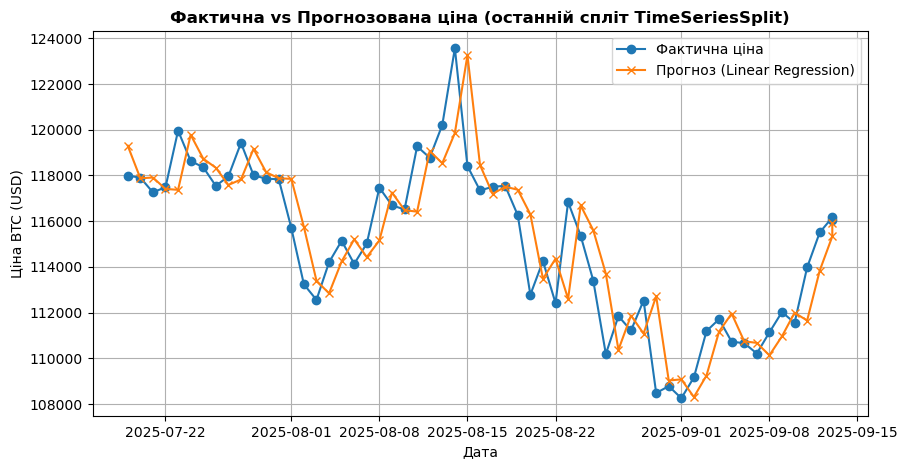

In [17]:
# 1. Фільтрація по BTC
df_btc = market_daily[market_daily["symbol"] == "BTC"].copy().reset_index(drop=True)

# Лаги (7 днів назад)
for lag in range(1, 8):
    df_btc[f"lag_{lag}"] = df_btc["price_usd"].shift(lag)

# Видалення пропусків
df_btc = df_btc.dropna().reset_index(drop=True)

# Ознаки та ціль
X = df_btc[[f"lag_{i}" for i in range(1, 8)]]
y = df_btc["price_usd"]

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

mae_scores, rmse_scores, r2_scores = [], [], []
last_split = None

for train_idx, test_idx in tscv.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_scores.append(mean_absolute_error(y_test, y_pred))
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    r2_scores.append(r2_score(y_test, y_pred))

    # Останній спліт для графіка
    last_split = (y_test.index, y_test, y_pred)

print("=== Time Series Cross-Validation ===")
print(f"MAE = {np.mean(mae_scores):.2f}")
print(f"RMSE = {np.mean(rmse_scores):.2f}")
print(f"R² = {np.mean(r2_scores):.3f}")

# Візуалізація 
test_idx, y_test, y_pred = last_split

plt.figure(figsize=(10,5))
plt.plot(df_btc["date"].iloc[test_idx], y_test, label="Фактична ціна", marker="o")
plt.plot(df_btc["date"].iloc[test_idx], y_pred, label="Прогноз (Linear Regression)", marker="x")
plt.xlabel("Дата")
plt.ylabel("Ціна BTC (USD)")
plt.title("Фактична vs Прогнозована ціна (останній спліт TimeSeriesSplit)", fontweight="bold")
plt.legend()
plt.grid(True)
plt.show()

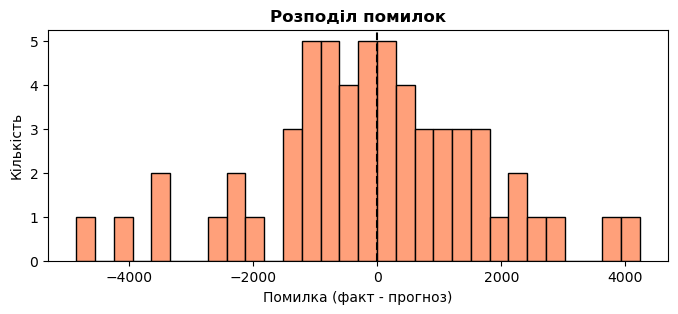

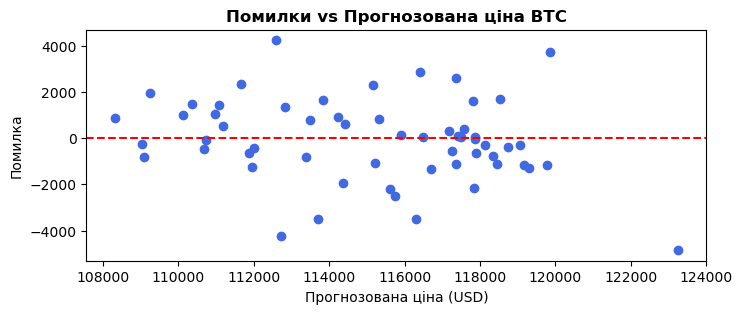


=== 5 найбільших помилок прогнозування: ===


,Фактична ціна,Прогнозована ціна,Помилка
321,118405.60,123256.62,4851.03
336,108480.31,112716.44,4236.14
329,116834.25,112600.72,4233.53
320,123560.99,119851.26,3709.73
326,112778.34,116297.89,3519.54


In [18]:
# Аналіз помилок на останньому спліті 
residuals = y_test - y_pred

# Гістограма помилок
plt.figure(figsize=(8,3))
plt.hist(
    residuals, 
    bins=30, 
    color="lightsalmon",
    edgecolor="black",
    )
plt.axvline(0, color="black", linestyle="--")
plt.title("Розподіл помилок", fontweight="bold")
plt.xlabel("Помилка (факт - прогноз)")
plt.ylabel("Кількість")
plt.show()

# Scatter plot: помилки vs прогнозовані значення
plt.figure(figsize=(8,3))
plt.scatter(
    y_pred, 
    residuals,  
    color="royalblue", 
    )
plt.axhline(0, color="red", linestyle="--")
plt.title("Помилки vs Прогнозована ціна BTC", fontweight="bold")
plt.xlabel("Прогнозована ціна (USD)")
plt.ylabel("Помилка")
plt.show()

# Знаходимо пости з найбільшими помилками
errors_df = pd.DataFrame({
    "Фактична ціна": y_test.values,
    "Прогнозована ціна": y_pred,
    "Помилка": np.abs(residuals)
})

# Топ-5 найбільших помилок
top_errors = errors_df.nlargest(5, 'Помилка')
print("\n=== 5 найбільших помилок прогнозування: ===")
display(top_errors.round(2))

**Висновки**

Модель Linear Regression змогла доволі добре відтворити загальну динаміку цін BTC: коефіцієнт детермінації R² ≈ 0.77 показує, що модель пояснює більшість коливань. Середня помилка (MAE ≈ 1.6–1.7k USD) є відносно невеликою для настільки волатильного активу, хоча точність все ж обмежена. Аналіз помилок показав, що:
- **Більшість прогнозів** мають відхилення в діапазоні ±2000 USD, тобто модель стабільно вловлює тренд.
- **Найбільші похибки** виникають у моменти різких злетів чи падінь, де лінійна регресія «згладжує» ринок і відстає від фактичних значень.
- **Розподіл залишків** симетричний, немає систематичного зсуву в один бік, що підтверджує нейтральність моделі.

**Практичний висновок:** базова ML-модель може бути корисною для оцінки загального тренду BTC у короткостроковому горизонті (7 днів), проте для більш точного прогнозу в умовах різких ринкових рухів потрібні складніші алгоритми.

# **F. Підсумок**

### 12. Рейтинг монет за співвідношенням прибуток/ризик

**Мета:**  Оцінити монети не лише за абсолютним прибутком (ROI), але й з урахуванням волатильності. Це дозволить визначити, які активи приносять найвищу віддачу на одиницю ризику.  
 


=== Sharpe ratio по монетах ===


,symbol,avg_return,volatility,roi_pct,sharpe_ratio
0,ADA,0.431,6.180,161.72,0.070
1,BTC,0.205,2.314,91.41,0.088
2,ETH,0.255,3.905,92.92,0.065
3,SOL,0.250,4.440,74.50,0.056
4,XRP,0.596,5.155,452.38,0.116


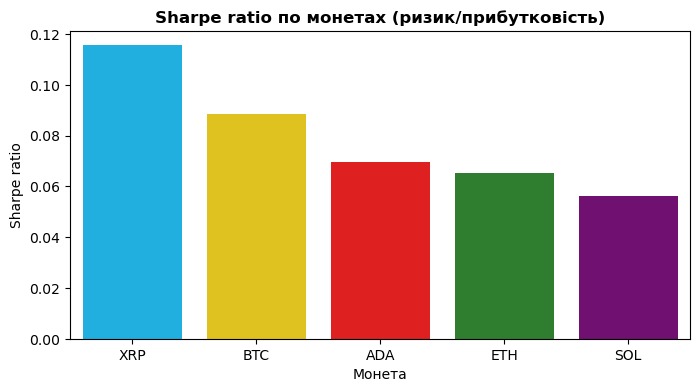

In [19]:
# Середня дохідність і волатильність
sharpe_df = (market_daily.groupby("symbol")["return_pct"].agg(avg_return="mean", volatility="std").reset_index())

# ROI з симуляційної таблиці
sharpe_df = sharpe_df.merge(sim_results[["symbol", "roi_pct"]].drop_duplicates("symbol"), on="symbol",how="left")

# 3. Sharpe ratio 
sharpe_df["sharpe_ratio"] = sharpe_df["avg_return"] / sharpe_df["volatility"]

print("\n=== Sharpe ratio по монетах ===")
display(sharpe_df[["symbol", "avg_return", "volatility", "roi_pct", "sharpe_ratio"]].round(3))

# --- Візуалізація ---
plt.figure(figsize=(8,4))
sns.barplot(
    data=sharpe_df.sort_values("sharpe_ratio", ascending=False),
    x="symbol",
    y="sharpe_ratio",
    hue="symbol",
    palette=coin_colors
)
plt.title("Sharpe ratio по монетах (ризик/прибутковість)", fontweight="bold")
plt.xlabel("Монета")
plt.ylabel("Sharpe ratio")

plt.show()

**Висновки:** Sharpe ratio показує, наскільки ефективно монета компенсує ризик своєю дохідністю:

- **XRP** — має найвищий Sharpe ratio (≈ **0.116**), тобто забезпечує найкраще співвідношення прибутковості до ризику. Це робить його найбільш ефективним активом у вибірці.  
- **BTC** — друге місце (≈ **0.088**). Біткоїн залишається відносно стабільним активом із помірним ризиком та дохідністю.  
- **ADA** — середній результат (≈ **0.070**), що говорить про непоганий баланс ризик/прибутковість.  
- **ETH** та **SOL** — найнижчі значення (≈ **0.065–0.053**). Вони демонструють вищу волатильність при близькій середній дохідності, що робить їх менш ефективними з точки зору ризик-менеджменту.

---

# 📌 **Фінальні висновки**

Проєкт продемонстрував комплексний підхід до аналізу криптовалют, поєднуючи описову статистику, візуалізацію, симуляцію інвестиційних стратегій, статистичні тести та ML-моделювання.


### 1. 📊 Базовий огляд
- **Ціни:** усі монети за рік зросли, але темпи різнились.  
- **Волатильність:** XRP та ADA найризикованіші; BTC і ETH — стабільніші.  
- **Просадки:** найбільші падіння в ADA, однак просадки спостерігалися у всіх монет.  

---

### 2. 🔗 Взаємозв’язки та ринкові фактори
- **Кореляції:** сновні криптовалюти (BTC, ETH, SOL) рухаються узгоджено та формують ринкове ядро, тоді як XRP не є повністю незалежним й може бути потенційно корисним активом для **диверсифікації портфеля**, адже ця монета може рухатися інакше, ніж більшість.   
- **Обсяги торгів:** scatterplot і t-тести показали, що для BTC і XRP високі обсяги значно підвищують дохідність; для ETH, SOL і ADA ефект не підтвердився.  
- **Сезонність:** виявлені патерни за днями й місяцями, але водночас варто зазначити, що результати отримані на основі даних лише за один рік. Це означає, що виявлені патерни можуть частково бути зумовлені **разовими подіями чи зовнішніми ринковими факторами**, а не стійкою закономірністю. 

---

### 3. 💰 Інвестиційні стратегії
- **Buy & Hold:** усі монети прибуткові; лідери — XRP (+450–480%) та ADA (+160–180%).  
- **DCA:** знижує ризики, але помітно обмежує прибуток (особливо у BTC).  
- **Buy on Dip:** найкраще спрацював для XRP та ADA; іноді кращий за Buy & Hold, але залежить від частоти падінь.  
- **Risk–Return Map:** XRP та ADA — високий прибуток при більших просадках; BTC та ETH — збалансовані; SOL — найслабший.  

---

### 4. ⚖️ Прибуток/Ризик (Sharpe ratio)
- **XRP** — найкраще співвідношення ризику/прибутку.  
- **BTC** — оптимальний «баланс»: нижчий ROI, але висока надійність.  
- **ETH, SOL, ADA** — менш ефективні, вищий ризик за слабшої дохідності.  

---

## ✅ Загальний підсумок
- **Для інвестора:** найбільш привабливими є XRP (як драйвер прибутку) і BTC (як стабілізатор).  
- **Для трейдера:** Buy & Hold і Buy on Dip вигідніші за DCA, але ризики від просадок залишаються.  
- **Для бізнес-кейсу:** поєднання описової статистики, стратегій і ML доводить, що комплексний підхід дозволяє краще зрозуміти крипторинок і приймати обґрунтовані рішення.  


In [20]:
# Збереження результатів у CSV 

# Маркет дані (повний датасет по днях)
market_daily.to_csv("data/market_daily.csv", index=False)

# Результати симуляцій
sim_results.to_csv("data/sim_results.csv", index=False)

print("Дані збережені у папку data/: market_daily.csv і simu_results.csv")

Дані збережені у папку data/: market_daily.csv і simu_results.csv
